🎉 POZİSYON TESPİTİ (4 Kilit Nokta): LEFT


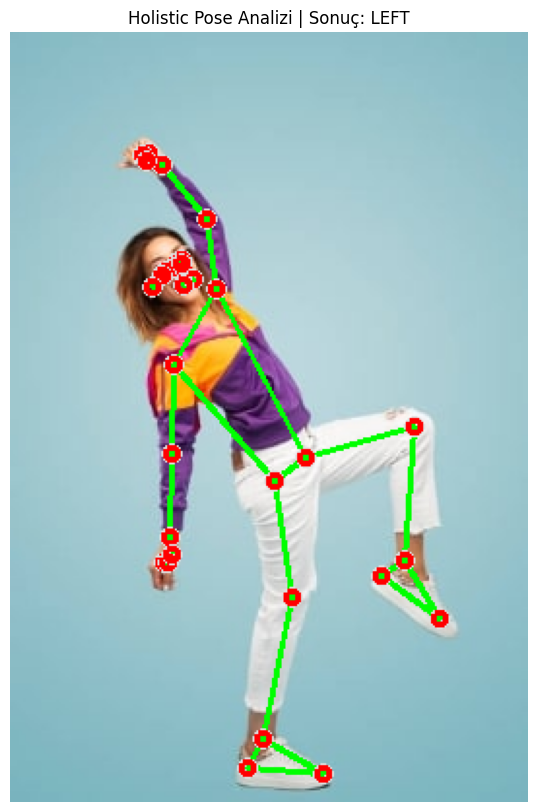

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic # Holistic modülü POSE estimation yapar
mp_pose = mp.solutions.pose

## BUNU CONSOLEDAN INPUT ALACAK ŞEKILDE GUNCELLEYECEGIM
IMAGE_PATH = r"C:\Users\endererkaya\OneDrive\Desktop\MIDTERM\pose-1.jpg"
# -------------------------------------------------

# Eşik değeri: Bileğin kendi omuz noktasından bu oranda YUKARIDA olması gerekir.
Y_THRESHOLD_RATIO = 0.15 # %15 eşik değeri kullandık.

def analyze_four_landmarks(landmarks):
    """Sadece Sol Omuz, Sağ Omuz, Sol Bilek ve Sağ Bilek noktalarına odaklanarak kol pozisyonunu belirler."""
    
    # 1. Kilit Noktaları Çıkarma
    left_wrist     = landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST]
    right_wrist    = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST]
    left_shoulder  = landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    
    # 2. Yükseklik Farklarını Hesaplama (Kendi Omuzu - Kendi Bileği)
    
    # Sol Kol Analizi: Sol Omuz Y - Sol Bilek Y
    left_diff_normalized = left_shoulder.y - left_wrist.y
    
    # Sağ Kol Analizi: Sağ Omuz Y - Sağ Bilek Y
    right_diff_normalized = right_shoulder.y - right_wrist.y
    
    # 3. Karar Verme Mantığı
    threshold_normalized = Y_THRESHOLD_RATIO 
    
    is_left_raised = left_diff_normalized > threshold_normalized
    is_right_raised = right_diff_normalized > threshold_normalized
    
    if is_left_raised and not is_right_raised:
        return "LEFT"
    
    elif is_right_raised and not is_left_raised:
        return "SAĞ KOL YUKARIDA (OMUZ KARŞILAŞTIRMASI)"
        
    elif is_left_raised and is_right_raised:
        return "İKİ KOL DA YUKARIDA (OMUZ KARŞILAŞTIRMASI)"
        
    else:
        return "KOLLAR YANLARDA VEYA AŞAĞIDA"


# --- Ana İşlem ---
image = cv2.imread(IMAGE_PATH)
if image is None:
    print(f"HATA: Resim {IMAGE_PATH} yolunda bulunamadı.")
    exit() 

img_h, img_w, _ = image.shape
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=1) as holistic:
    
    results = holistic.process(image_rgb)
    annotated_image = image_rgb.copy()
    
    detected_arm_status = "TESPİT BAŞARISIZ"
    
    if results.pose_landmarks:
        
        # 1. Kol Pozisyonunu Analiz Et (Sadece 4 noktayı kullanıyoruz)
        detected_arm_status = analyze_four_landmarks(results.pose_landmarks)
        
        # 2. Çizimleri Yapma (Görsel kanıt için tüm iskelet çizilir)
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=3),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2)
        )
        
        print(f"🎉 POZİSYON TESPİTİ (4 Kilit Nokta): {detected_arm_status}")
    
    else:
        print("⚠️ İnsan figürü algılanamadı.")


# 3. Sonucu Görselleştirme
plt.figure(figsize=(10, 10))
plt.imshow(annotated_image)
plt.title(f"Holistic Pose Analizi | Sonuç: {detected_arm_status}")
plt.axis('off')
plt.show()